<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение
### Семинар 12. Введение в байесовские методы

<br />
<br />
2 декабря 2021

### Напоминание. Теорема Байеса

$$
    P(A | B) = \frac{P(B | A) P(A)}{\int P(B | A) P(A) dA} = \frac{P(B | A) P(A)}{P(B)}
$$

В машинном обучении это транслируется так:
$$
    P(\theta | Y) = \frac{P(Y | \theta) P(\theta)}{\int P(Y | \theta) P(\theta)},
$$

где $P(Y | \theta)$ --- функция правдоподобия данных при заданных параметрах модели, $P(\theta)$ --- априорное распределение параметров, $P(Y) = \int P(Y | \theta) P(\theta)$ --- маргинальное правдоподобие данных.

Общая схема применения байесовского подхода:
1. специфицировать модель (то есть задать функцию правдоподобия)
2. указать априорное распределение параметров. Cложная часть. Как правило, априорное распределение должно быть достаточно неинформативным, но при этом отражать какие-то _априорные_ знания о параметрах. Есть целый [документ](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) с "рецептами" по выбору априорного распределения.
3. применить теорему Байеса :)

На практике практически всегда вычисление апостериорного распределения оказывается невозможным. 
На помощь приходят либо различного рода аппроксимации, либо Markov Chain Monte Carlo.

### Сопряженные распределения. Пример

Если апостериорное распределение $p(\theta | Y)$ для функции правдоподобия $p(y | \theta)$ из того же семейства распределений, что и априорное $p(\theta)$, такой prior называется сопряженным (conjugate) для правдоподобия $p(y | \theta)$. Такие распределения удобны для работы, потому что в этом случае апостериорное распределение считается аналитически.

Примеры пар сопряженных распределений.

| Likelihood | Prior | 
|------------|-------|
| (Multivariate) Gaussian   | (Multivariate) Gaussian | 
| Bernoulli | Beta |
| Poisson | Gamma |
| Gaussian | Gamma |

Рассмотрим простейший пример с нечестной монеткой. Пусть монетка выпадает орлом с вероятностью $\theta$ (в случае $\theta = 0.5$ монетка честная). Результаты подкидывания монетки получаются из распределения $P(coin = head | \theta) = Bernoulli(\theta)$. Это будет нашей функцией правдоподобия.

Как нам оценить параметр $\theta$ из данных?

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.datasets
from scipy.special import expit
from sklearn.linear_model import LogisticRegression

SEED = 1234
np.random.seed(SEED)  # for reproducibility

In [2]:
# generate some data
theta = 0.7
coin_flips = scipy.stats.bernoulli.rvs(theta, size=10)  # let's use small data

<BarContainer object of 2 artists>

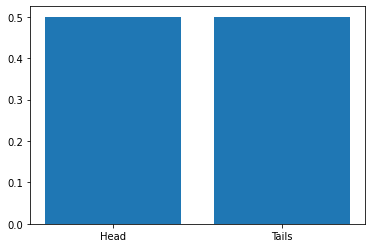

In [3]:
names = ['Head', 'Tails']
data = coin_flips.mean(), 1 - coin_flips.mean()
plt.bar(names, data)

Простейший (фреквентистский) вариант --- получить максимум правдоподобия:

In [4]:
theta_mle = coin_flips.mean()
print('MLE for \\theta =', theta_mle)

MLE for \theta = 0.5


**Задание.** Что произошло? Докажите, что MLE-оценка для $\theta$ это выборочное среднее.

Для правдоподобия Бернулли сопряженным априорным распределением будет бета-распределение $Beta(\alpha, \beta)$.

Апостериорным распределением будет $Beta(\alpha + \sum x_i, \beta + n - \sum x_i)$.

У нас нет оснований полагать что-то об $\alpha$ и $\beta$, поэтому выберем $\alpha=\beta=1$. Это распределение совпадает с равномерным распределением --- мы считаем, что $\theta$ может быть где угодно на отрезке $[0, 1]$.

In [5]:
a_prior = 1.
b_prior = 1.
beta_prior = scipy.stats.beta(a=a_prior, b=b_prior)
beta_posterior = scipy.stats.beta(a = a_prior + coin_flips.sum(), 
                                  b = b_prior + len(coin_flips) - coin_flips.sum())

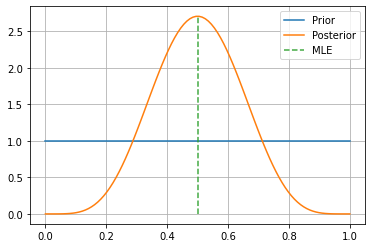

In [6]:
# let's plot
x_ = np.linspace(0, 1, 100)

plt.plot(x_, beta_prior.pdf(x_), label='Prior')
plt.plot(x_, beta_posterior.pdf(x_), label='Posterior')
plt.plot([theta_mle, theta_mle], [0, beta_posterior.pdf(theta_mle)], linestyle='--', alpha=0.9, label='MLE')
plt.grid()
plt.legend()

Давайте посмотрим, что будет в случае большего количества данных.

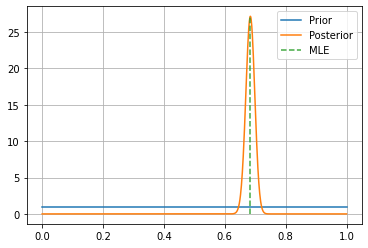

In [7]:
coin_flips = scipy.stats.bernoulli.rvs(theta, size=1000)  # let's use big data (ok, not so big)
beta_posterior = scipy.stats.beta(a = 1. + coin_flips.sum(), b = 1. + len(coin_flips) - coin_flips.sum())
theta_mle = coin_flips.mean()

x_ = np.linspace(0, 1, 1000)
plt.plot(x_, beta_prior.pdf(x_), label='Prior')
plt.plot(x_, beta_posterior.pdf(x_), label='Posterior')
plt.plot([theta_mle, theta_mle], [0, beta_posterior.pdf(theta_mle)], linestyle='--', alpha=0.9, label='MLE')
plt.grid()
plt.legend()

**Задание**. Попробуйте поменять параметры априорного распределение на другие. Что будет в этом случае c MLE-оценкой? Что произойдет с увеличением количества данных?

Этот пример слишком простой. Во-первых, пространство параметров у нас одномерно. Во-вторых, нам "повезло" и для функции правдоподобия есть сопряженное распределение.

В многомерном случае (как правило), нет такой роскоши.

### Логистическая регрессия

Логистическая регрессия моделирует вероятность, что классифицируемый объект окажется в положительном классе:

$$ p(y_i | \theta) = Bernoulli(p_i) $$
$$ p_i = p(y_i = 1| \theta) = \sigma(\theta_1 x_{i1} + \theta_2 x_{i2} + \ldots + \theta_m x_{im} )$$

Это наша функция правдоподобия.

(Напоминание: $\sigma(t) = 1 / (1 + \exp(-t))$)

Для набора данных $Y = [y_1, \ldots, y_N]^\top$ мы будем предполагать условную независимость:

$$
    P(Y | \theta) = \prod_{i=1}^{N} p(y_i | \theta)
$$

Для такой функции правдоподобия нет сопряженного распределения :( Поэтому нам придется применять другие методы для нахождения апостериорного.

In [8]:
# load some data
raw_data = sklearn.datasets.load_breast_cancer()
X = raw_data['data'][:, [0, 4]]
feature_names = raw_data['feature_names'][[0, 4]]
Y = raw_data['target']
target_names = raw_data['target_names']

# normalize the data
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_std = np.where(np.isclose(X_std, 0), 1., X_std)
X_normed = (X - X_mean) / X_std

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_normed, Y)

print('Predicting breast cancer based on %s' % ', '.join(feature_names))

Predicting breast cancer based on mean radius, mean smoothness


Посмотрим на датасет:

In [9]:
def plot_classes(X, Y, feature_names, target_names, title):
    colors = ['red', 'green']
    for i, cancer_type in enumerate(target_names):
        where = np.where(Y == i)
        plt.scatter(X[where, 0], X[where, 1], c=colors[i], label=cancer_type)

    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(loc='best')

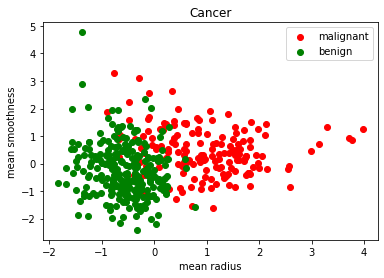

In [10]:
plot_classes(X_train, Y_train, feature_names, target_names, title='Cancer')

Давайте выберем априорное распределение для наших параметров $\theta$. Для простоты возьмем нормальное распределение с большой дисперсией:

In [11]:
theta_prior = scipy.stats.multivariate_normal(mean = np.zeros(2), cov=10*np.eye(2))

Лог-правдоподобие данных:

In [12]:
def log_likelihood(theta): 
    dot_product = theta.dot(X_train.T)
    sign = -np.sign(Y_train - 0.5)  # -1 if Y==1, +1 if Y==0
    
    log_likelihood = -np.log(1.0 + np.exp(sign * dot_product)).sum(axis=-1)
    
    return log_likelihood

Ненормированное апостериорное распределение:
    $$ p(\theta | Y) \propto p(Y | \theta) p(\theta) $$
    
Нам удобнее считать логарифм:
    $$ \log p(\theta | Y) = \log p(Y | \theta) + \log p(\theta) + C $$

In [13]:
def log_unnormed_posterior(theta):
    return log_likelihood(theta) + theta_prior.logpdf(theta)

Text(0, 0.5, '$\\theta_2$')

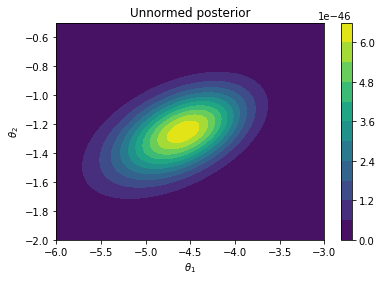

In [14]:
theta_1, theta_2 = np.meshgrid(np.linspace(-6., -3., 100), np.linspace(-2, -.5, 100))  # (100, 100)
theta = np.dstack((theta_1, theta_2))  # (100, 100, 2)

plt.contourf(theta_1, theta_2, np.exp(log_unnormed_posterior(theta)), levels=10)
plt.colorbar()

plt.title('Unnormed posterior')
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\theta_2$')

### MCMC

#### Метрополис-Хастингс

Напомним схему алгоритма Метрополиса-Хастингса.

0. Выберем произвольную точку $x_0$ и симметричное распределение $Q(x_{n+1} | x_n)$ (proposal rule)

На каждой итерации:
1. Сгенерируем точку $x_{n+1}$ из распределения $Q(x_{n+1} | x_n)$
2. Посчитаем acceptance ratio
    $$ \alpha = \frac{p(x_{n+1})}{p(x_n)} $$
3. Сгенерируем случайное $u \sim U[0, 1]$.
4. Примем новый сэмпл, если $u \leq \alpha$

In [15]:
x_0 = np.zeros(2)  # why not?
x_current = x_0

n_accepts = 0
n_iter = 10000

metropolis_samples = []

for _ in range(n_iter):
    # write your code here

In [16]:
print('Efficiency: %.2f' % (n_accepts / n_iter))

Efficiency: 0.79


Как правило, из полученных сэмплов выкидывают первые, начальные сэмплы, полученные, когда марковская цепь еще не сошлась к стационарному распределению. Этот период называют burn in или warp up (прогрев). Кроме того, соседние сэмплы оказываются коррелированными, поэтому обычно их "разреживают", беря не все сэмплы, а только каждый N-ый. 

Для простоты мы зададим какие-то относительно разумные значения для прогрева и разреживания.

In [17]:
burnin = 1000
sample_sparsifier = 5

theta_samples = np.array(metropolis_samples[burnin:][::sample_sparsifier])

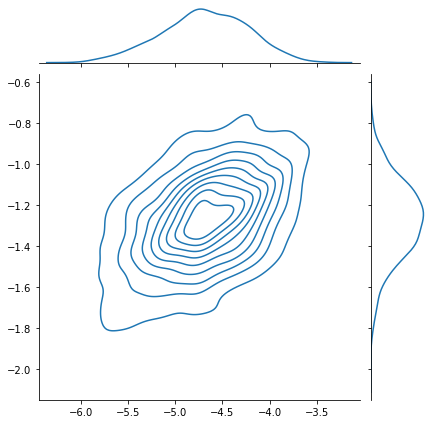

In [18]:
sns.jointplot(x=theta_samples[:,0], y=theta_samples[:,1], kind='kde')

Довольно неплохо приблизили апостериорное распределение. Можно видеть, что апостериорное распределение параметров довольно широкое --- в случае "точечной" оценки эта информация теряется.

### Предсказательное распределение

Окей, но как нам предсказывать класс для _новых_ пациентов?

Посмотрим на апостериорное распределение для $y_*$:
$$ p(y_* | Y) = \frac{p(y_*, Y)}{p(Y)} = \int \frac{p(y_*, Y, \theta)}{p(Y)} d\theta = \int \frac{p(y_* | Y, \theta) p(Y, \theta)}{p(Y)} d\theta = \int p(y_* | Y, \theta) p(\theta | Y) d\theta = \int p(y_* | \theta) p(\theta | Y) d\theta $$

В последнем равенстве мы воспользовались условной независимостью исходов.

Это можно интепретировать так: мы _усредняем_ предсказания $p(y_* | \theta)$ по _всем_ возможным моделям $\theta$, взвешивая их настолько, насколько они вероятны при имеющихся данных.

Как обычно, этот интеграл не вычислим :) Мы можем воспользоваться методом Монте-Карло:
1. Сэмплируем $\theta_i$ из распределения $p(\theta | Y)$.
2. Сэмплируем $y_*$ из распределения $p(y_* | \theta_i)$.

Таким образом, получим сэмплы из распределения $p(y_* | Y)$.


Давайте посмотрим на тестовую выборку:

In [34]:
def predict(X):
    prob = expit(theta_samples.dot(X.T))  # logistic function
    
    rv = scipy.stats.bernoulli.rvs(prob)  # samples from predictive distribution
    
    means = np.mean(rv, axis=0)
    variances = np.var(rv, axis=0)
    
    return means, variances

In [35]:
means, variances = predict(X_test)

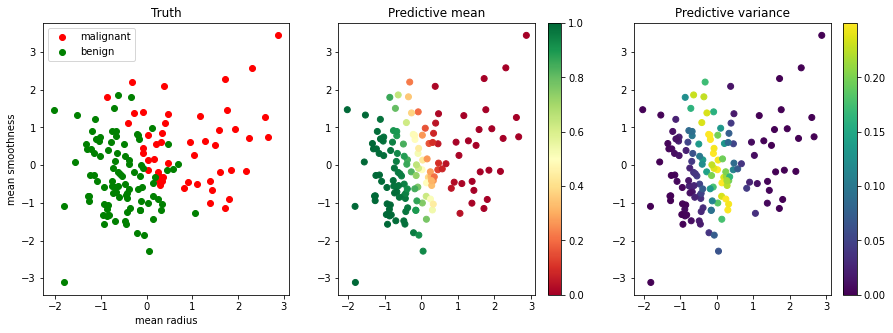

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_classes(X_test, Y_test, feature_names, target_names, title='Truth')

plt.subplot(132)
plt.scatter(X_test[..., 0], X_test[..., 1], c=means, cmap='RdYlGn')
plt.title("Predictive mean")
plt.colorbar()

plt.subplot(133)
plt.scatter(X_test[..., 0], X_test[..., 1], c=variances, cmap='viridis')
plt.title("Predictive variance")
plt.colorbar()

Как видим, на границе классов среднее наших предсказаний близко к 0.5, а дисперсия выше, чем в глубине классов. Это демонстрирует неуверенность (неопределенность) модели --- действительно, классы перемешаны, и сделать уверенное предсказание на границе сложно в рамках нашей модели.

### Фреймворки

Мы написали много бойлерплейт-кода, но для Python есть несколько фреймворков для байесовского вывода, упрощающих жизнь.

* **PyMC3**
    
    Библиотека на основе `theano` (эффективно мертвом фреймворке). Тем не менее, хорошая документация, много примеров и туториалов. А также очень простая визуализация.

* **Bambi**
    
    Надстройка над PyMC3 для упрощения реализации Generalized Linear Models.

* **Pyro**
    
    Библиотека на основе `pytorch`.

* **TensorFlow Probability**
    
    Модуль для `tensorflow`. 

Давайте попробуем вывести апостериорные распределения для параметров логистической регрессии по _всем_ признакам. Воспользуемся `pyro`.

In [37]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc

In [38]:
from pyro.infer import Predictive

Подготовим данные

In [39]:
X = raw_data['data']
feature_names = raw_data['feature_names']
Y = raw_data['target']
target_names = raw_data['target_names']

# normalize the data
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_std = np.where(np.isclose(X_std, 0.), 1., X_std)
X_normed = (X - X_mean) / X_std

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_normed, Y)

# convert to torch
X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), \
    torch.tensor(Y_train).float(), torch.tensor(Y_test).float()

n_features = X.shape[-1]

Заведем модель логистической регрессии. В качестве априорных распределений снова возьмем "широкие" гауссианы.

In [40]:
burnin = 1000
n_samples = 9000

def logistic_regression(x, y):
    intercept = pyro.sample("intercept", dist.Normal(torch.tensor([0.0]), torch.tensor([10.0])))
    theta = pyro.sample("theta", dist.Normal(torch.zeros(n_features), 10.0*torch.ones(n_features)))
    
    linear = intercept + torch.matmul(theta, x)
    
    obs = pyro.sample("obs", dist.Bernoulli(logits = linear), obs=y)
    
    return obs

Используем более "продвинутый" метод MCMC, который называется NUTS (No U-Turn Sampler).

NUTS использует градиент, чтобы более эффективно исследовать апостериорное распределение. (То есть proposal rule более сложное, чем просто гауссиана).

В детали NUTS вдаваться не будем, поскольку это выходит за рамки курса.

**Warning:** следующая клетка может выполнятся долго.

In [41]:
kernel = mcmc.NUTS(logistic_regression, jit_compile=False)

posterior = mcmc.MCMC(kernel,
                      num_samples=n_samples,
                      warmup_steps=burnin,
                      num_chains=1,
                      disable_progbar=False)

posterior.run(X_train.T, Y_train)

Sample: 100%|█████████████████████████████████████| 10000/10000 [39:17,  4.24it/s, step size=2.94e-02, acc. prob=0.908]


Получим сэмплы из апостериорного распределения

In [43]:
samples = posterior.get_samples()

In [45]:
samples['theta'] = samples['theta'][::sample_sparsifier]
samples['intercept'] = samples['intercept'][::sample_sparsifier]

Давайте посмотрим на маргинальные распределения сэмплов.

In [46]:
theta_samples = samples['theta'].numpy()

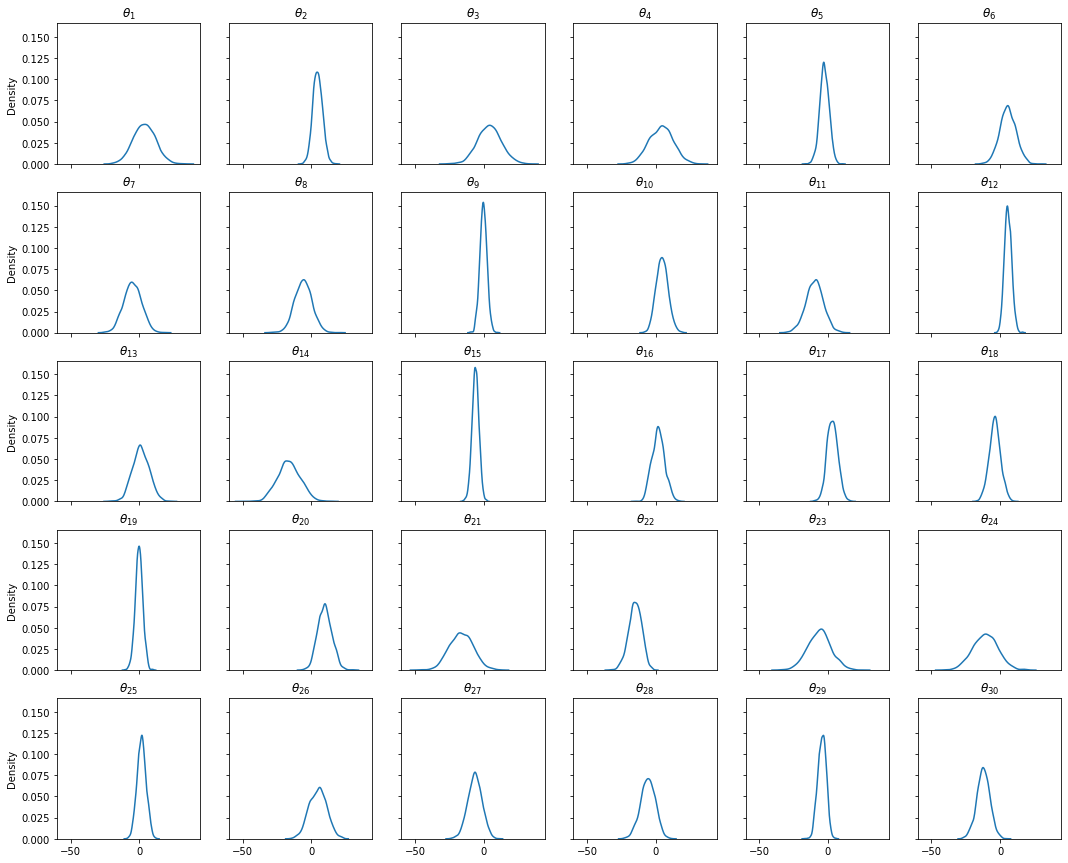

In [47]:
n_rows = 5
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15), sharey=True, sharex=True)

for i in range(theta_samples.shape[-1]):
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    sns.kdeplot(ax=ax, x=theta_samples[:, i])
    ax.set_title('$\\theta_{%d}$' % (i+1))

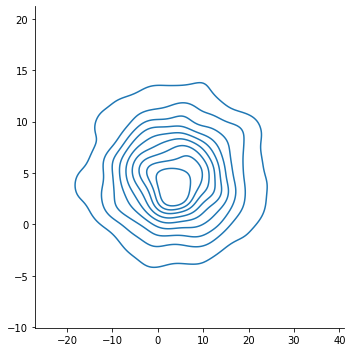

In [48]:
sns.displot(x=theta_samples[:, 0], y=theta_samples[:, 1], kind='kde')

**Вопрос**: что можно сказать о распределениях параметров? Какие параметры оценились уверенно, а в каких есть большая степень неопределенности?

Попробуем что-нибудь предсказать.

In [49]:
predictive = Predictive(logistic_regression, samples)(X_test.T, None)

In [50]:
means = predictive['obs'].mean(axis=0)
variance = predictive['obs'].var(axis=0)

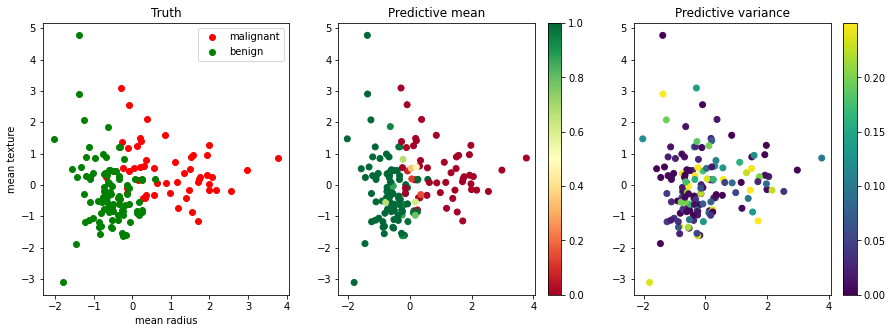

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plot_classes(X_test[:, [0, 4]], Y_test, feature_names, target_names, title='Truth')

plt.subplot(132)
plt.scatter(X_test[:, 0], X_test[:, 4], c=means, cmap='RdYlGn')
plt.title("Predictive mean")
plt.colorbar()

plt.subplot(133)
plt.scatter(X_test[:, 0], X_test[:, 4], c=variances, cmap='viridis')
plt.title("Predictive variance")
plt.colorbar()

### Материалы

Интерактивная визуализация различных алгоритмов MCMC: https://chi-feng.github.io/mcmc-demo/

Концептуальное введение в MCMC: https://arxiv.org/abs/1909.12313

### Это еще не всё

Байесовский взгляд учитывает неопределенность, присущую задачам машинного обучения. Байесовские модели выдают не фиксированные ответы, а распределение ответов. 

MCMC -- один из методов получения апостериорного распределения. Его главный недостаток -- высокая вычислительная сложность. Помимо этого, есть и другие способы получать (аппроксимированно) апостериорные распределения (такие как вариационный вывод). 

Кроме того, как вы помните, есть "особое" правдоподобие Multivariate Gaussian, для которого сопряженным априорным будет Multivariate Gaussian. Это приводит к еще одной мощной байесовской модели гауссовских процессов. Но это уже отдельная история для следующего семестра :)